In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
import cvxpy as cvp
from CSSS import CSSS
import time 
#import cvxopt as co
%matplotlib inline

Import the data and drop rows with NAN.

In [35]:
df=pd.read_csv('input_data.csv')
df=df.dropna()


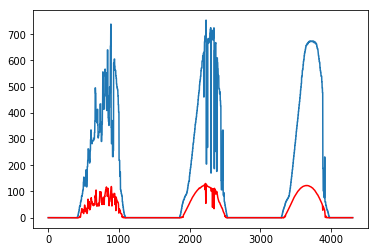

In [3]:
### Look at the solar proxies
plt.plot(df['Irradiance'])
plt.plot(df['IrradianceProxy'],'-r')

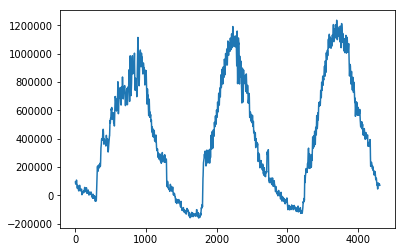

In [65]:
### Look at the total load shape
plt.plot(df['Reactive_Power_Total'])


# Play around with time indexing in df

In [144]:
# Play around with time indexing in df
N=len(df)
print(df['Reactive_Power_Total'][4])
# print(df)
tmp = pd.to_datetime(df['Unnamed: 0'].iloc[1859])-pd.to_datetime(df['Unnamed: 0'].iloc[0])
# print(dir(tmp))
print(tmp)
print(tmp.days)
print(tmp.components.hours)

tmp = pd.to_datetime(df['Unnamed: 0'].iloc[4292])
# print(dir(tmp))
print(tmp)
print(tmp.day)
print(tmp.hour)


# a=np.empty([6,4])
# a[1][3]=np.array([1,2,3])
# print(a)
a=[[],[],[],[]]
a[1] = [1,2,3]
a[0] = ['rrr']
print(a)

y = [[[] for i in range(3)] for j in range(4)]
y[2][1] = np.array([1,2,3])
print(y)

a = b=3
a=1
print([a, b])


93436.82848606702
1 days 06:59:00
1
6
2015-10-21 23:45:00
21
23
[['rrr'], [1, 2, 3], [], []]
[[[], [], []], [[], [], []], [[], array([1, 2, 3]), []], [[], [], []]]
[1, 3]


In [329]:
## Organise data in appropriate form to support time-varying regressors
N=len(df)
numD = (np.ceil(np.divide(N,1440.0))).astype(np.int64)

# Define windows for different regressors during a day
Q = np.array(df['Reactive_Power_Total']/1000)
Ir = np.array(df['IrradianceProxy'])
windH = [0, 6, 12, 18] # hour indices when a new window starts
# windH = range(24) # hour indices when a new window starts
# windH = [0, 6, 8, 10, 12, 14, 16, 18]
numW = len(windH)
Qbig = [[[] for i in range(numW)] for j in range(numD)]
Irbig = [[[] for i in range(numW)] for j in range(numD)]

# Loop through X data
initStep = pd.to_datetime(df['Unnamed: 0'].iloc[0])
initDay = initStep.day

for i in range(N):
    #print(i)
    curStep = pd.to_datetime(df['Unnamed: 0'].iloc[i])
    curDay = curStep.day - initDay
    curHour = curStep.hour
    
    indices = np.where(curHour-np.array(windH)>=0)
    curWind = indices[0][len(indices[0])-1]
    
    Qbig[curDay][curWind].append(Q[i])
    Irbig[curDay][curWind].append(Ir[i])

# Build Xtilda matrix for Q
for i in range(numD):
    Qaux = []
    for j in range(numW):
        tmp = np.array(Qbig[i][j]) 
        tmplen = len(tmp)
        tba = tmp.reshape((tmplen,1)) # to be added
        if j==0:
            Qaux = tba
            Iaux = np.ones((tmplen,1))
        else:       
            Qaux = sc.linalg.block_diag(Qaux,tba)
            Iaux = sc.linalg.block_diag(Iaux,np.ones((tmplen,1)))
    if i==0:
        Qtilda = Qaux
        Itilda = Iaux
    else:
        Qtilda = np.vstack((Qtilda,Qaux))
        Itilda = np.vstack((Itilda,Iaux))
Xtilda = np.hstack((Itilda,Qtilda))

# Build Xtilda2 matrix for Ir
for i in range(numD):
    Iraux = []
    for j in range(numW):
        tmp = np.array(Irbig[i][j]) 
        tmplen = len(tmp)
        tba = tmp.reshape((tmplen,1)) # to be added
        if j==0:
            Iraux = tba
            Iaux = np.ones((tmplen,1))
        else:       
            Iraux = sc.linalg.block_diag(Iraux,tba)
            Iaux = sc.linalg.block_diag(Iaux,np.ones((tmplen,1)))
    if i==0:
        Irtilda = Iraux
        Itilda = Iaux
    else:
        Irtilda = np.vstack((Irtilda,Iraux))
        Itilda = np.vstack((Itilda,Iaux))
Xtilda2 = np.hstack((Itilda,Irtilda))

# print(len(Xtilda))
# print(N)
# np.savetxt('Xtilda.out', Xtilda, delimiter=',')



In [330]:
# Feeder-level Solar Disagg Using the New Class
N=len(df)
CSSS_solar = CSSS(np.array(df['Real_Power_Total']/1000))  ## Instantiate model with aggregate signal, Y
#CSSS_solar.addSource(np.vstack((np.ones((1,N)),np.array(df['Reactive_Power_Total']/1000))).transpose(), alpha = 1, name = 'Load',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff_l2',gamma=0)  ## Add a model for Load:  Q + intercept term as regressor
CSSS_solar.addSource(Xtilda, alpha = 1, name = 'Load',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff_l1',gamma=0)  ## Add a model for Load:  Q + intercept term as regressor
#CSSS_solar.addSource(np.array(df['IrradianceProxy']), alpha = 0.1, name = 'Solar',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff1_ss',gamma=0.0) ## Add a model for Solar: Irradiance Proxy Only as regressor.
CSSS_solar.addSource(Xtilda2, alpha = 0.1, name = 'Solar',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff1_ss',gamma=0.0) ## Add a model for Solar: Irradiance Proxy Only as regressor.

# Constrain Solar to be <= 0 . 
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'] <= 0 )
# Constrain Load to be >=0
CSSS_solar.addConstraint(CSSS_solar.models['Load']['source'] >= 0 )
# Constraint Solar to be 0, when solar proxy is 0
irrProxy = df['IrradianceProxy']
idx0 = np.where(irrProxy<1)[0]
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'][idx0] == 0 )

start=time.time()
a=CSSS_solar.constructSolve('ECOS',True,500)
print("It took {} seconds in centralized CSSS".format(time.time()-start))
print(CSSS_solar.models['Solar']['theta'].value)
print(CSSS_solar.models['Load']['theta'].value)
    


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +1e+08  4e-01  1e-03  1e+00  2e+04    ---    ---    1  1  - |  -  - 
 1  -9.093e+05  -9.093e+05  +3e+06  8e-03  3e-05  2e+00  3e+02  0.9813  1e-04   2  1  1 |  0  0
 2  -7.137e+04  -7.137e+04  +2e+05  7e-04  2e-06  2e-01  2e+01  0.9201  3e-04   3  2  2 |  0  0
 3  -7.165e+04  -7.165e+04  +2e+05  6e-04  2e-06  1e+00  2e+01  0.1093  5e-01   4  3  3 |  0  0
 4  -3.795e+04  -3.795e+04  +1e+05  3e-04  1e-06  2e+00  1e+01  0.5463  1e-01   4  3  3 |  0  0
 5  -3.626e+03  -3.625e+03  +2e+04  6e-05  3e-07  6e-01  3e+00  0.7791  9e-03   4  4  4 |  0  0
 6  +3.856e+03  +3.856e+03  +1e+04  3e-05  1e-07  5e-01  1e+00  0.6702  2e-01   6  5  5 |  0  0
 7  +1.069e+04  +1.069e+04  +4e+02  1e-06  3e-09  5e-02  5e-02  0.9890  3e-02   6  5  5 |  0  0
 8  +1.102e+04  +1.102e+04  +5e+01  2e-07  8e-

# Perform disaggregation with time-varying regressors

In [7]:
## Organises X data from df in appropriate matrix form (Xhat) to support optimization with time-varying regressors
# The function assumes the the regressors are of the form Y_i = X_i * k_i + R_i, where k_i and R_i are scalars and i indicates one time window
# Matrix notation for all time windows: Y = Xhat * [R; k]. Structure of Xhat = [blkdiag(ones_vectors) | blkdiag(Xaux)]

def buildMat(df,Nstd,dfName,normFact,windH):
    N=len(df)
    numD = (np.ceil(np.divide(N,Nstd))).astype(np.int64) # number of days in dataset
    X = np.array(df[dfName]/normFact) # vector data to organize in appropriate form
    numW = len(windH) # number of windows
    Xbig = [[[] for i in range(numW)] for j in range(numD)]

    # Loop through X vector and create Xbig matrix
    initStep = pd.to_datetime(df['Unnamed: 0'].iloc[0])
    initDay = initStep.day

    for i in range(N):
        curStep = pd.to_datetime(df['Unnamed: 0'].iloc[i])
        curDay = curStep.day - initDay
        curHour = curStep.hour

        indices = np.where(curHour-np.array(windH)>=0)
        curWind = indices[0][len(indices[0])-1]

        Xbig[curDay][curWind].append(X[i])

    # Build Xhat matrix (which multiplies the vector of time-varying regressors) using Xbig
    for i in range(numD):
        Xaux = []
        for j in range(numW):
            tmp = np.array(Xbig[i][j]) 
            tmplen = len(tmp)
            tba = tmp.reshape((tmplen,1)) # to be added
            if j==0:
                Xaux = tba
                Iaux = np.ones((tmplen,1))
            else:       
                Xaux = sc.linalg.block_diag(Xaux,tba)
                Iaux = sc.linalg.block_diag(Iaux,np.ones((tmplen,1)))
        if i==0:
            Xtilda = Xaux
            Itilda = Iaux
        else:
            Xtilda = np.vstack((Xtilda,Xaux))
            Itilda = np.vstack((Itilda,Iaux))
    Xhat = np.hstack((Itilda,Xtilda))
    return Xhat


In [30]:
# Feeder-level Solar Disagg Using the New Class & formulation for time-varying regressors
N=len(df)
Qhat = buildMat(df,1440.0,'Reactive_Power_Total',1000,[0,6,9,12,15,18])
#Irhat = buildMat(df,1440.0,'IrradianceProxy',1,[0,6,9,12,15,18])
#Irhat = buildMat(df,1440.0,'IrradianceProxy',1,[0]) # using [0] as a window is actually simulating without any window
Irhat = np.array(df['IrradianceProxy'])

CSSS_solar = CSSS(np.array(df['Real_Power_Total']/1000))  ## Instantiate model with aggregate signal, Y
CSSS_solar.addSource(Qhat, alpha = 15.67, name = 'Load',costFunction='l2',regularizeTheta='l2',beta=10,regularizeSource='diff_l2',gamma=500)  ## Add a model for Load:  Q + intercept term as regressor
CSSS_solar.addSource(Irhat, alpha = 1, name = 'Solar',costFunction='l2',regularizeTheta='l2',beta=0,regularizeSource='diff1_ss',gamma=0.0) ## Add a model for Solar: Irradiance Proxy Only as regressor.

# Constrain Solar to be <= 0 . 
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'] <= 0 )
# Constrain Load to be >=0
CSSS_solar.addConstraint(CSSS_solar.models['Load']['source'] >= 0 )
# Constraint Solar to be 0, when solar proxy is 0
irrProxy = df['IrradianceProxy']
idx0 = np.where(irrProxy<1)[0]
CSSS_solar.addConstraint(CSSS_solar.models['Solar']['source'][idx0] == 0 )

start=time.time()
a=CSSS_solar.constructSolve('ECOS',True,500)
print("It took {} seconds in centralized CSSS".format(time.time()-start))
print(CSSS_solar.models['Solar']['theta'].value)
print(CSSS_solar.models['Load']['theta'].value)
    


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +3e+09  4e-01  8e-05  1e+00  4e+05    ---    ---    1  1  - |  -  - 
 1  -4.272e+06  -4.269e+06  +9e+08  9e-02  2e-05  3e+03  1e+05  0.6939  1e-02   2  2  2 |  0  0
 2  -3.719e+06  -3.717e+06  +3e+08  2e-02  9e-06  2e+03  4e+04  0.6417  1e-02   3  2  2 |  0  0
 3  -9.851e+05  -9.846e+05  +6e+07  3e-03  1e-06  5e+02  6e+03  0.8461  5e-03   3  2  2 |  0  0
 4  -1.841e+06  -1.840e+06  +5e+07  9e-04  1e-06  8e+02  5e+03  0.2203  3e-01   4  3  2 |  0  0
 5  -4.137e+06  -4.136e+06  +4e+07  4e-04  1e-06  2e+03  4e+03  0.3979  4e-01   4  3  2 |  0  0
 6  -5.404e+06  -5.402e+06  +3e+07  4e-04  1e-06  2e+03  4e+03  0.1582  7e-01   4  3  3 |  0  0
 7  -4.746e+06  -4.744e+06  +2e+07  3e-04  7e-07  2e+03  2e+03  0.5141  3e-01   4  3  3 |  0  0
 8  -5.179e+06  -5.177e+06  +2e+07  3e-04  6e-

[[-9.16376283e-11]
 [-9.17329097e-11]
 [-9.15599293e-11]
 ...
 [-9.16702941e-11]
 [-9.16445033e-11]
 [-9.16598431e-11]]


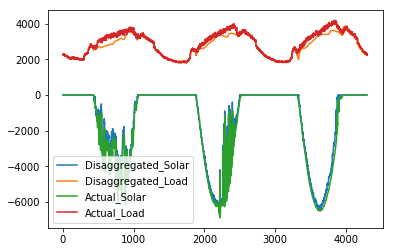

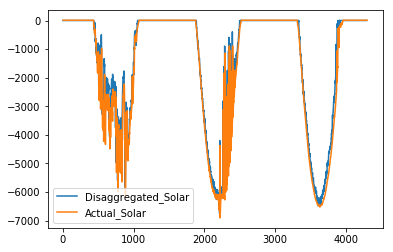

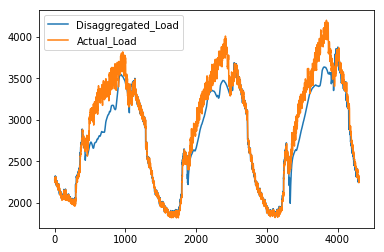

[132.75558937183166, 132.75558937183166, 132.75558937183166]


In [31]:
print(CSSS_solar.models['Solar']['source'].value)
plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')

plt.plot(-1*df['Real_Power_PV']/1000, label = 'Actual_Solar')
plt.plot(df['Real_Power_Total']/1000+df['Real_Power_PV']/1000, label = 'Actual_Load')

plt.legend()
plt.show()


plt.plot(CSSS_solar.models['Solar']['source'].value, label = 'Disaggregated_Solar')
plt.plot(-1*df['Real_Power_PV']/1000, label = 'Actual_Solar')

plt.legend()
plt.show()


plt.plot(CSSS_solar.models['Load']['source'].value, label = 'Disaggregated_Load')
plt.plot(df['Real_Power_Total']/1000+df['Real_Power_PV']/1000, label = 'Actual_Load')

plt.legend()
plt.show()


N = len(df)
solarAct = -1*df['Real_Power_PV']/1000
loadAct = df['Real_Power_Total']/1000+df['Real_Power_PV']/1000
solarDisag = []
for val in CSSS_solar.models['Solar']['source'].value:
    solarDisag.append(float(val))
loadDisag = []
for val in CSSS_solar.models['Load']['source'].value:
    loadDisag.append(float(val))

MAE = (np.sum(np.absolute(solarDisag-np.array(solarAct)))+np.sum(np.absolute(loadDisag-np.array(loadAct))))/(2*N)
MAE1 = (np.sum(np.absolute(solarDisag-np.array(solarAct))))/(N)
MAE2 = (np.sum(np.absolute(loadDisag-np.array(loadAct))))/(N)

print([MAE, MAE1, MAE2])
